# <b>1 <span style='color:#FFDB00; font-weight: bold;'>|</span> Introduction</b>

An autoencoder is a neural network that is trained in an unsupervised way to learn how to represent a chunk of data as a smaller matrix, and can reconstruct it back to its original form.  
An autoencoder is composed of two parts -an encoder and a decoder. The encoder compresses information, and the decoder reconstructs the original information from that compressed form.  
We can use an autoencoder for a variety of tasks, such as:
- Dimentionality reduction
- Language translation
- Image Generation
- Anomaly detection
- Image Segmentation

And so much more! In this notebook, I will show you how to build an autoencoder that can remove noise from images

<adenoising><img src="https://i.ibb.co/McpDByt/image-c.png" alt="image-c" border="0"></a>

The encoder compresses the input image into a latent space or 'bottleneck', where the information about the image is stored. The decoder then uses that compressed representation as the input to reconstruct the image with no noise.  
But there is a problem with this method, compressing the image to a smaller latent space results in a significant loss of data, and so the output of the decoder is a bit blurry (you can notice this in the above diagram). Fortunately, there are ways to tackle this problem:  

In this notebook, we will be building an autoencoder that denoises images of size `(224, 224, 3)`. The neural network will be fully convolutional, which means we can train it on images of any shape. We will be training the model on larger images ,images with shape `(384, 384, 3)`, so that it can learn more patterns and will be able to perform better on smaller images of shape `(224, 224, 3)`, making the reconstruction more detailed (less blurriness).  

Also, we will not build the decoder to reconstruct images based solely on the compressed representation, but will also pass in the output of previous layers of the encoder, this will allow the decoder to know more information about the original image, making the reconstruction more detailed. This is called the U-Net architecture,  
![](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png)

U-Nets are popular for image segmentation tasks, and they can also be used for denoising images

# <b>2 <span style='color:#FFDB00; font-weight: bold;'>|</span> Imports</b>
- **For ML Models**: tensorflow  
- **For Data Processing**: numpy  
- **For Data Visualization**: matplotlib

In [1]:
# For ML Models
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.losses import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.metrics import *
from tensorflow.keras import regularizers
import tensorflow.keras.backend as K
from tensorflow.keras.preprocessing.image import load_img

# For Data Processing
import numpy as np

# For Data Visualization
import matplotlib.pyplot as plt

# Miscellaneous
import os
import random

# Turn off warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

# <b>3 <span style='color:#FFDB00; font-weight: bold;'>|</span> Variables & Functions</b>

<h2>3.1 <span style='color:#FFDB00; font-weight: bold;'>|</span> Image Sizes</h2>  

We will train out autoencoder to remove noise from images of size `(384,384,3)`, and watch its performance on images of size `(224,224,3)`

In [2]:
TRAIN_SIZE = 384
INFERENCE_SIZE = 224

<h2>3.2 <span style='color:#FFDB00; font-weight: bold;'>|</span> Train-Test Split</h2>  

In [3]:
main_dir = '/kaggle/input/flickr-image-dataset/flickr30k_images/flickr30k_images/'
all_image_paths = [main_dir+file for file in os.listdir(main_dir) if file.endswith('.jpg')]

print('Total number of images:', len(all_image_paths))

Total number of images: 31783


We have ~32k images, we will use 25k images for training and the rest for testing and validation

In [4]:
train_image_paths = all_image_paths[:25000]
test_image_paths = all_image_paths[25000:]

<h2>3.3 <span style='color:#FFDB00; font-weight: bold;'>|</span> Function to open images</h2>  

In [5]:
def open_images(paths, size=TRAIN_SIZE):
    '''
    Given an array of paths to images, this function opens those images,
    and returns them as an array of shape (None, Height, Width, Channels)
    '''
    images = []
    for path in paths:
        image = load_img(path, target_size=(size, size, 3))
        image = np.array(image)/255.0 # Normalize image pixel values to be between 0 and 1
        images.append(image)
    return np.array(images)

<h2>3.4 <span style='color:#FFDB00; font-weight: bold;'>|</span> Function to add noise</h2>  

In [6]:
def add_noise(images, amount=0.1):
    '''
    Given an array of images [a shape of (None, Height, Width, Channels)],
    this function adds gaussian noise to every channel of the images
    '''
    # Create a matrix with values with a mean of 0 and standard deviation of "amount"
    noise = np.random.normal(0, amount, images.shape[0]*images.shape[1]*images.shape[2]*images.shape[3]).reshape(images.shape)
    # Add noise to images
    noise_img = images+noise
    return noise_img

Example usage of functions `open_images` and `add_noise` :

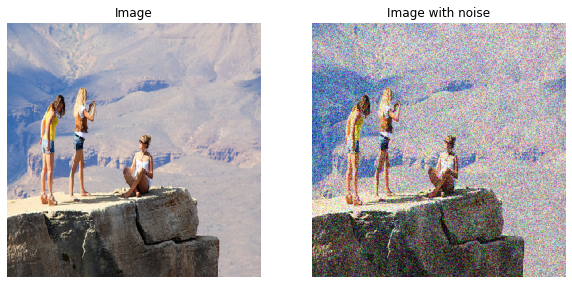

In [7]:
image = open_images([train_image_paths[27]])
noise_img = add_noise(image, amount=0.2)

fig = plt.figure(figsize=(10, 5))
# Plot Image
fig.add_subplot(1, 2, 1)
plt.axis('off')
plt.title('Image')
plt.imshow(image[0])
# Plot Image with noise
fig.add_subplot(1, 2, 2)
plt.axis('off')
plt.title('Image with noise')
plt.imshow(noise_img[0])

plt.show()

# <b>4 <span style='color:#FFDB00; font-weight: bold;'>|</span> Data Generator</b>

This generator function returns batches on which the neural network can train on

In [8]:
def datagen(paths, size=TRAIN_SIZE, batch_size=5):
    '''
    Given an array of images to paths,
    this function returns batch of images as (noise_image, real_image)
    '''
    for x in range(0, len(paths), batch_size):
        batch_paths = paths[x:x+batch_size]
        batch_images = open_images(batch_paths, size=size)
        amount = random.uniform(0,0.2) # Amount of noise = random value between 0 and 0.2
        noise_images = add_noise(batch_images, amount=amount)
        yield noise_images, batch_images

# <b>5 <span style='color:#FFDB00; font-weight: bold;'>|</span> Model</b>

<h2>5.1 <span style='color:#FFDB00; font-weight: bold;'>|</span> Build Model</h2>  

The neural network is fully convolutional, so it can be applied on images of any shapes.  
To make the model accept variable size inputs, we set the input shape parameter to `(None, None, 3)`

In [9]:
image = Input(shape=(None,None,3))

# Encoder
l1 = Conv2D(64, (3,3), padding='same', activation='relu',
            activity_regularizer=regularizers.l1(10e-10))(image)     
l2 = Conv2D(64, (3,3), padding='same', activation='relu',
            activity_regularizer=regularizers.l1(10e-10))(l1)

l3 = MaxPooling2D(padding='same')(l2)
l3 = Dropout(0.3)(l3)
l4 = Conv2D(128, (3,3), padding='same', activation='relu',
            activity_regularizer=regularizers.l1(10e-10))(l3)
l5 = Conv2D(128, (3,3), padding='same', activation='relu',
            activity_regularizer=regularizers.l1(10e-10))(l4)

l6 = MaxPooling2D(padding='same')(l5)
l7 = Conv2D(256, (3,3), padding='same', activation='relu',
            activity_regularizer=regularizers.l1(10e-10))(l6)

#Decoder
l8 = UpSampling2D()(l7)
l9 = Conv2D(128, (3,3), padding='same', activation='relu',
           activity_regularizer=regularizers.l1(10e-10))(l8)
l10 = Conv2D(128, (3,3), padding='same', activation='relu',
            activity_regularizer=regularizers.l1(10e-10))(l9)

l11 = add([l5,l10])
l12 = UpSampling2D()(l11)
l13 = Conv2D(64, (3,3), padding='same', activation='relu',
            activity_regularizer=regularizers.l1(10e-10))(l12)
l14 = Conv2D(64, (3,3), padding='same', activation='relu',
            activity_regularizer=regularizers.l1(10e-10))(l13)

l15 = add([l14,l2])

decoded = Conv2D(3, (3,3), padding='same', activation='relu',
                activity_regularizer=regularizers.l1(10e-10))(l15)
model = Model(image, decoded)

In [10]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 6 1792        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 6 36928       conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, None, None, 6 0           conv2d_1[0][0]                   
______________________________________________________________________________________________

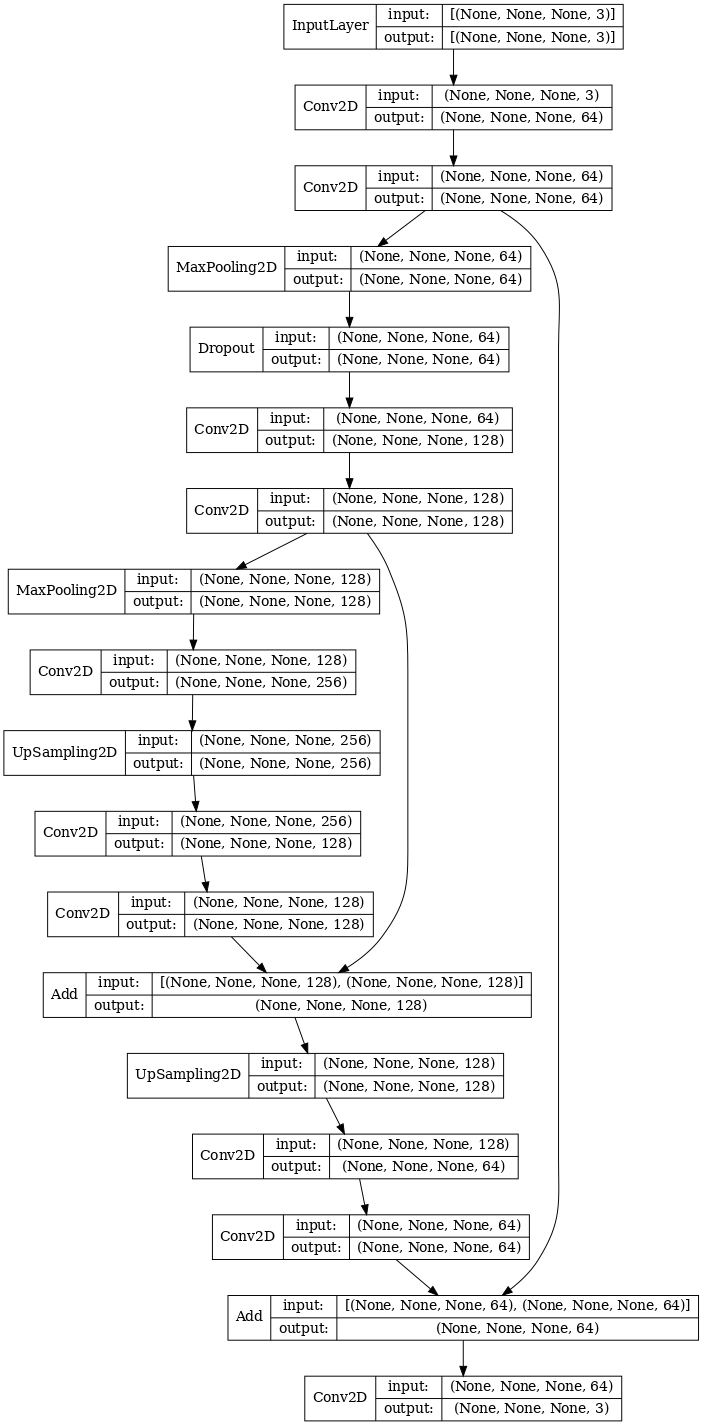

In [11]:
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=False, dpi=70)

<h2>5.2 <span style='color:#FFDB00; font-weight: bold;'>|</span> Compile Model</h2>  

In [12]:
model.compile(optimizer=RMSprop(learning_rate=0.0001),
             loss='binary_crossentropy')

<h2>5.3 <span style='color:#FFDB00; font-weight: bold;'>|</span> Train Model</h2>  

Train model on images of shape `TRAIN_SIZE`, and a batch size of 10

In [13]:
batch_size=10
steps = int(len(train_image_paths)/batch_size)
epochs = 3
for epoch in range(epochs):
    model.fit(datagen(train_image_paths, size=TRAIN_SIZE, batch_size=batch_size), epochs=1, steps_per_epoch=steps)

2500/2500 [==============================] - 1071s 428ms/step - loss: 0.4948


<h2>5.4 <span style='color:#FFDB00; font-weight: bold;'>|</span> Evaluate Model</h2>  

Evaluate the model's performance on images of shape `INFERENCE_SIZE`

In [14]:
batch_size=10
steps = int(len(test_image_paths)/batch_size)
model.evaluate(datagen(test_image_paths, size=INFERENCE_SIZE, batch_size=batch_size), steps=steps)

678/678 [==============================] - 153s 223ms/step - loss: 0.4973


0.49731168150901794

# <b>6 <span style='color:#FFDB00; font-weight: bold;'>|</span> Result</b>

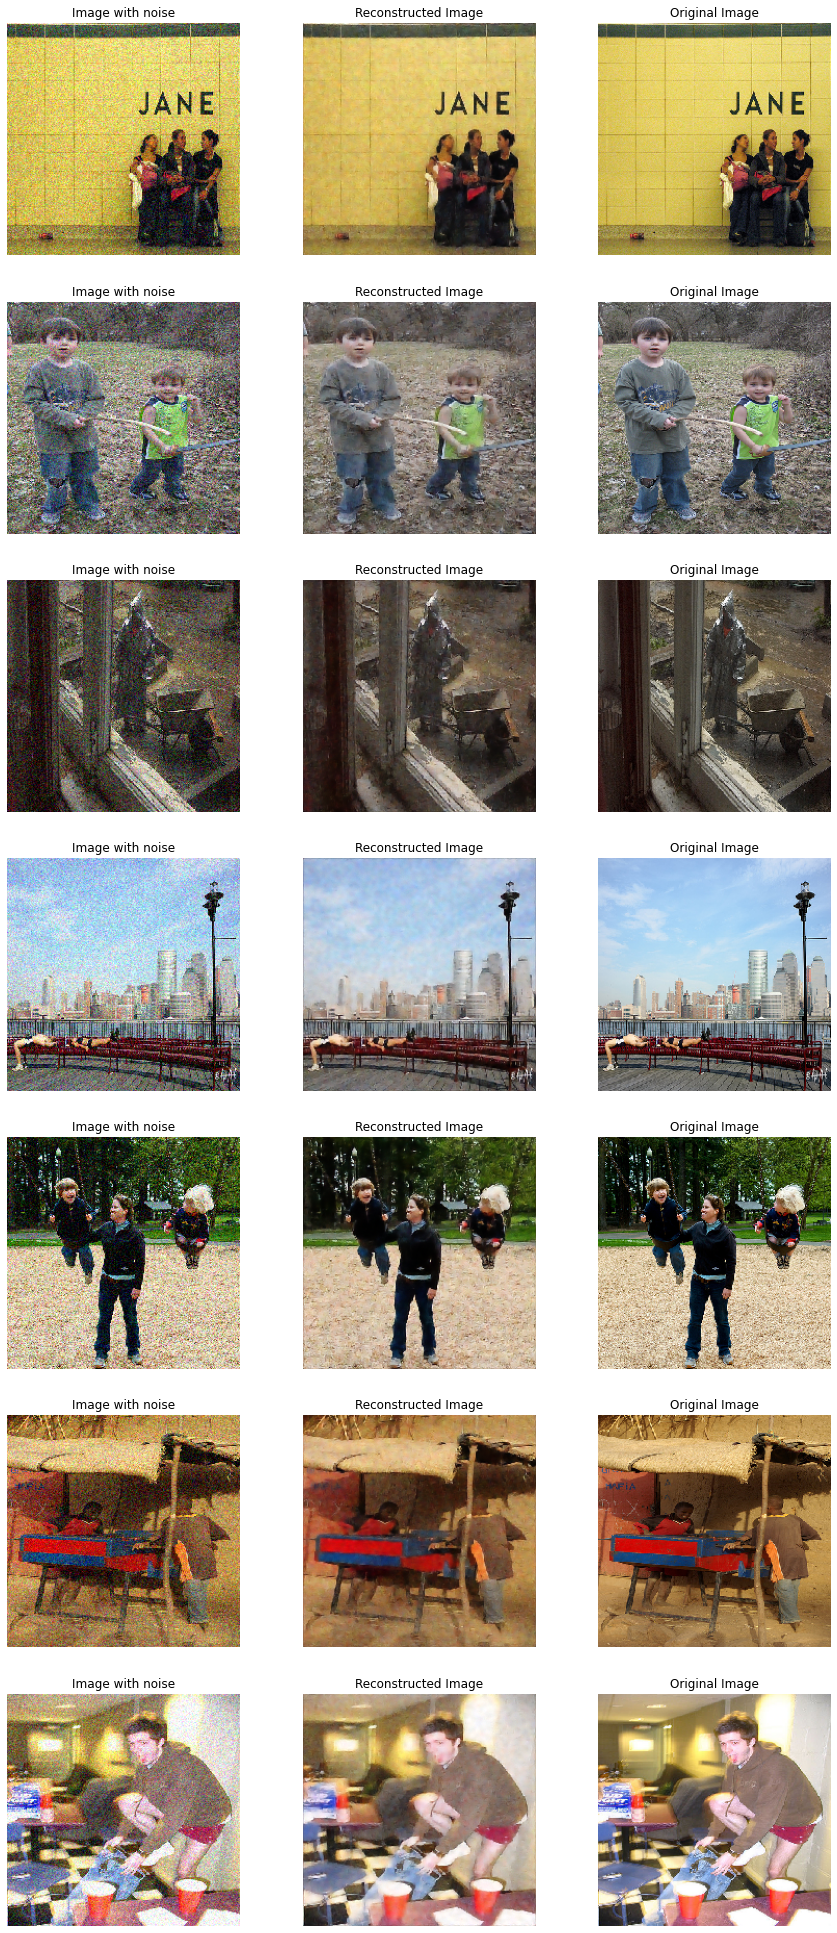

In [15]:
def plot_results(noise_image, reconstructed_image, image):
    w = 15
    h = len(noise_image)*5
    fig = plt.figure(figsize=(w, h))
    columns = 3
    rows = len(noise_image)
    for i in range(1, rows*columns, columns):
        fig.add_subplot(rows, columns, i)
        plt.axis('off')
        plt.title('Image with noise')
        plt.imshow(noise_images[int((i-1)/columns)])
    
        fig.add_subplot(rows, columns, i+1)
        plt.axis('off')
        plt.title('Reconstructed Image')
        plt.imshow(reconstructed[int((i-1)/columns)])
        
        fig.add_subplot(rows, columns, i+2)
        plt.axis('off')
        plt.title('Original Image')
        plt.imshow(images[int((i-1)/columns)])
    
    plt.show()
    
batch_size = 7

paths = random.sample(test_image_paths, batch_size)
images = open_images(paths, size=INFERENCE_SIZE)
# Amount of noise = random value between 0.1 and 0.15
amount = random.uniform(0.1,0.15)
noise_images = add_noise(images, amount=amount)
reconstructed = model.predict(noise_images)

plot_results(noise_images, reconstructed, images)